# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [494]:
# Load pickled data
import pickle

# Training data are in traffic-signs-data folder

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [495]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [496]:
# My helper functions for visualize and debug
import csv

# Load sign name database and create a map that we can use later
id_to_sign = {} # map for storing id to sign name mapping
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        id_to_sign[row[0]] = row[1]

# Output single image
def visual(X):
    image = X.squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image,cmap="gray")

# Output traffic sign with a string label
def visual_with_label(X,Y):
    image = X.squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image,cmap="gray")
    plt.figtext(0,1,id_to_sign[str(Y)])

def visual_with_top_k(X,y):
    image = X.squeeze()
    plt.figure(figsize=(2,2))
    plt.imshow(image,cmap="gray")
    buf = ""
    for i in range(len(y.indices[0])):
        buf += "%s %f%%\n" % (
            id_to_sign[str(y.indices[0][i])], 
            y.values[0][i])
    
    plt.figtext(0,1,buf)
    
# Visualize 20 picked data in the set
def visual_20(X,Y):
    data = range(250,30000,1500)
    for index in data:
        image = X[index].squeeze()
        #print(image)
        #print(np.mean(image))
        plt.figure(figsize=(2,2))
        plt.imshow(image,cmap="gray")
        plt.figtext(0.5,0,id_to_sign[str(Y[index])],ha="center")
        #filename = "sample/%d.png" % i
        #plt.savefig(filename)

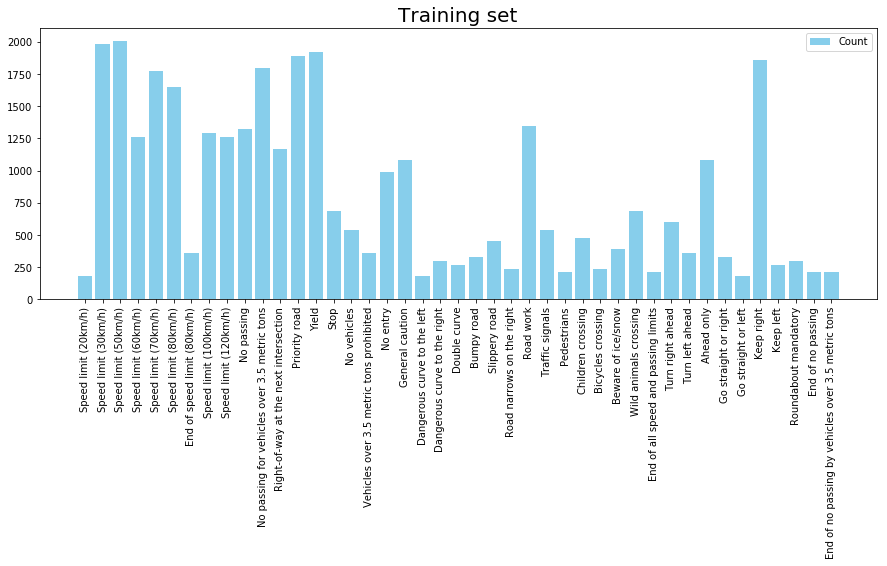

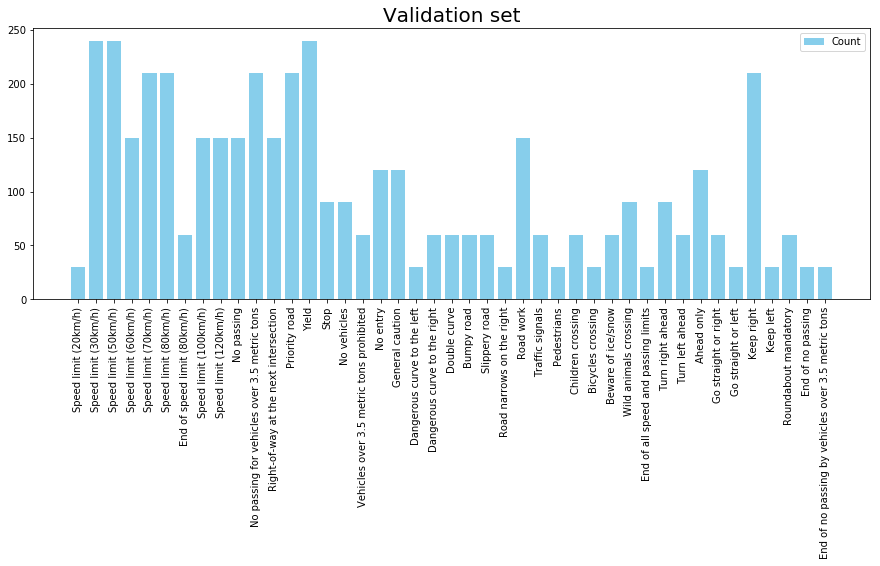

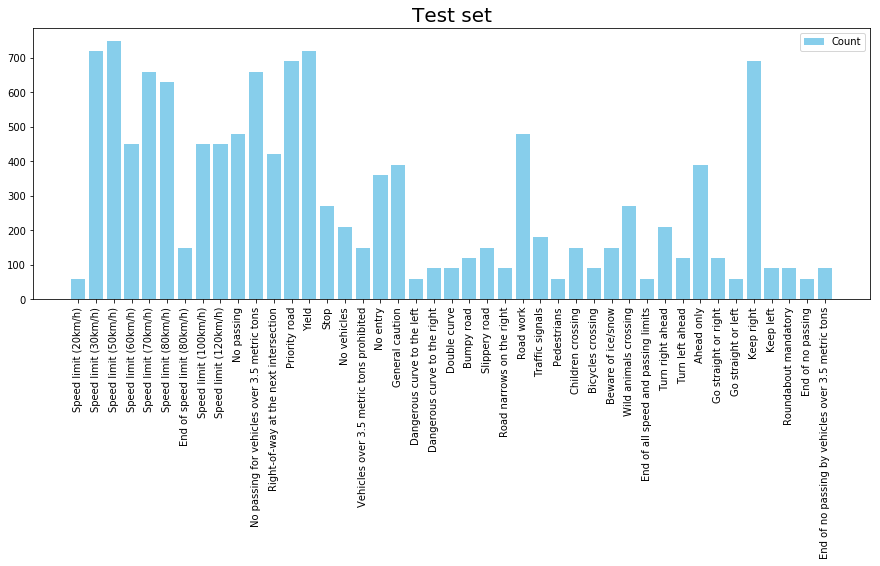

In [497]:
# Show some statistics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# display distribution of given dataset
def plt_distribution(data, title):
    counter = Counter(data) # output a map of label:count
    counts = []
    labels = []
    for i in range( len(set(data)) ):
        counts.append(counter[i])
        labels.append(id_to_sign[str(i)])
        
    fig, ax = plt.subplots( figsize=(15,5) )
    ind = np.arange(len(set(data))) 
    width = 0.8
    rects1 = ax.bar(ind, counts, width,
                color='SkyBlue', label='Count')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation="vertical")
    ax.legend()
    ax.set_title(title, fontdict={"fontsize":20})

    plt.show()
        
plt_distribution(y_train, "Training set")
plt_distribution(y_valid, "Validation set")
plt_distribution(y_test, "Test set")

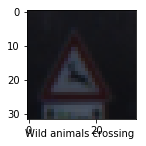

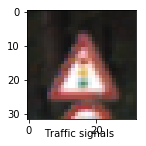

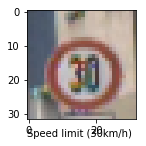

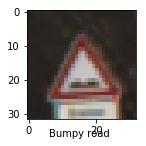

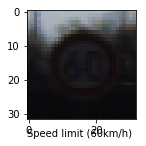

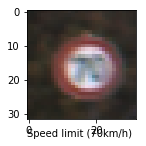

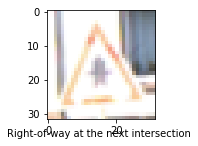

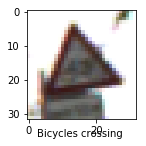

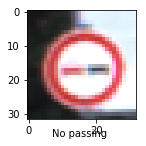

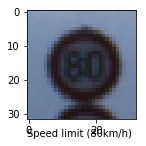

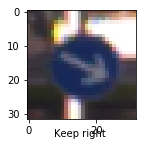

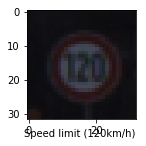

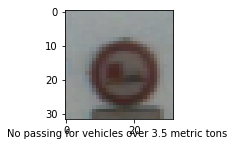

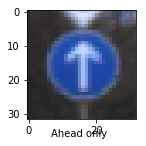

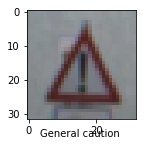

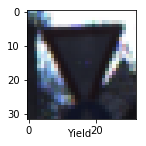

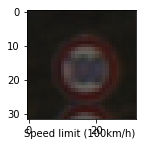

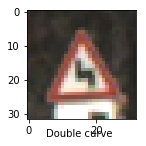

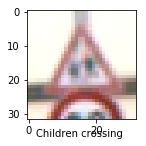

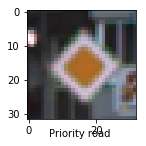

In [498]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

visual_20(X_train,y_train)

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [499]:
from sklearn.utils import shuffle
import numpy as np
from skimage import exposure

#X_train, y_train = shuffle(X_train, y_train)

def preprocess_img(rgb):
    # Convert to grayscale
    # https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

    new = np.ndarray(shape=(32,32,1),dtype=np.float32)
    mode = 1
    if mode==1:
        # equalize exposure after grayscale
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        
        # we use grayscale anyway.
        # colour doesn't outperforms grayscale one
        y = (0.2989 * r + 0.5870 * g + 0.1140 * b).astype(np.float32)
        #u = (0.492*(b-y)).astype(np.float32)
        #v = (0.877*(r-y)).astype(np.float32)
        #new[:,:,0] = (y/255.0)*2.0-1.0
        new[:,:,0] = (exposure.equalize_adapthist(y/255.0))*2.0-1.0
    elif mode == 2:
        # equalize exposure before grayscale
        rgb = exposure.equalize_adapthist(rgb)
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        new[:,:,0] = ((0.2989 * r + 0.5870 * g + 0.1140 * b)/255.0).astype(np.float32)
    elif mode == 3:
        # graysacle without green channel
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        new[:,:,0] = ((0.2989 * r + 0 * g + 0.1140 * b)/255.0).astype(np.float32)
    elif mode == 4:
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        tmp = ((0.2989 * r + 0 * g + 0.1140 * b)/255.0).astype(np.float32)
        new[:,:,0] = exposure.equalize_adapthist(tmp)
    else:
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        y = (0.2989 * r + 0.5870 * g + 0.1140 * b).astype(np.float32)
        new[:,:,0] = ( (y/255.0)*2.0-1.0) .astype(np.float32)
    
    return new

def preprocess(X):
    X_new = []
    for i in range(len(X)):
        X_new.append( preprocess_img(X[i]) )
        
    return X_new

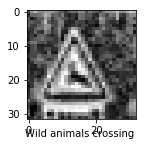

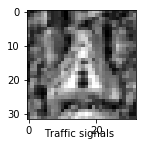

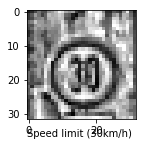

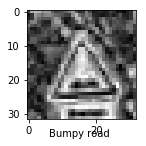

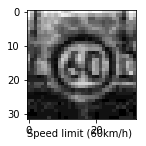

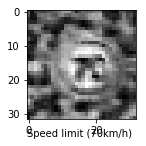

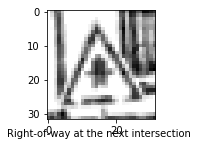

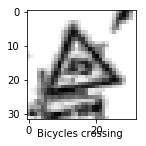

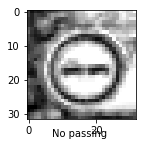

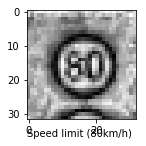

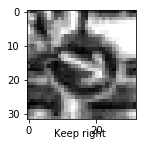

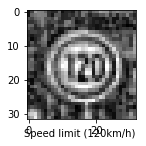

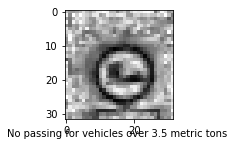

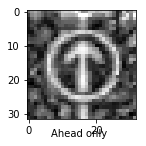

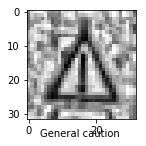

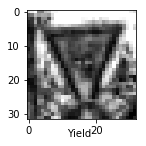

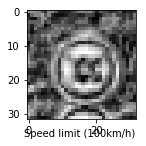

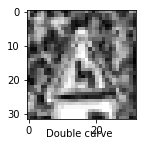

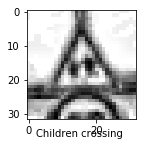

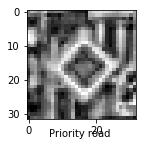

In [500]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Use cached processed image, which saves time when tuning the network
CACHE = False
BUILD_CACHE = False
training_cache = "traffic-signs-data.processed/X_train.p"
validation_cache = "traffic-signs-data.processed/X_valid.p"
testing_cache = "traffic-signs-data.processed/X_test.p"


if CACHE:
    with open(training_cache, mode='rb') as f:
        X_train = pickle.load(f)
    with open(validation_cache, mode='rb') as f:
        X_valid = pickle.load(f)
    with open(testing_cache, mode='rb') as f:
        X_test = pickle.load(f)
else:
    # preprocess all the data
    X_train = preprocess(X_train)
    X_valid = preprocess(X_valid)
    X_test = preprocess(X_test)
    
    if BUILD_CACHE:
        with open(training_cache, mode='wb') as f:
            pickle.dump(X_train,f)
        with open(validation_cache, mode='wb') as f:
            pickle.dump(X_valid,f)
        with open(testing_cache, mode='wb') as f:
            pickle.dump(X_test,f)

visual_20(X_train,y_train)



### Model Architecture

In [501]:
import tensorflow as tf

# Training parameters
EPOCHS = 20
BATCH_SIZE = 64
# Learn rate here
LEARN_RATE = 0.001

In [502]:
from tensorflow.contrib.layers import flatten

# Exp 1
# Vanilla LeNet for digits recognition and just modify output class from 10 to n_classes
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes
    # change output class from 10 to n_classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Exp 2
# Put both Conv1 and Conv2 into fully connected layer and apply dropout
def LeNet2(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 14x16x6+5x5x16. Output = 1576.
    #fcA   = tf.concat(concat_dim=1,values=[tf.nn.dropout(flatten(conv1), keep_rate), flatten(conv2)])
    fcA   = tf.concat(concat_dim=1,values=[
                    tf.nn.dropout(flatten(conv1), keep_rate), 
                    tf.nn.dropout(flatten(conv2), keep_rate)])

    # Extra Fully Connected Layer: Input: 1576. Output = 400
    fc0_W = tf.Variable(tf.truncated_normal(shape=(1576, 400), mean = mu, stddev = sigma))
    fc0_b = tf.Variable(tf.zeros(400))
    fc0   = tf.matmul(fcA, fc0_W) + fc0_b

    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes
    # change output class from 10 to n_classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Exp 3
# Vanilla LeNet with dropout after convolution layers
#
# visualization output
def LeNet3(x, output=""):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    if(output=="conv1"): # for visualization
        return conv1

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    if(output=="conv2"): # for visualization
        return conv2
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    # Apply dropout after f
    fc0   = tf.nn.dropout(flatten(conv2), keep_rate)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes
    # change output class from 10 to n_classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


In [503]:
x = tf.placeholder(tf.float32, (None, 32, 32,1)) # input as 32x32 grayscale image
y = tf.placeholder(tf.int32, (None)) # y label
one_hot_y = tf.one_hot(y, n_classes) # labels in one hot encoding

# we don't have dropout except in training mode, which dropout rate are given via feed dict
keep_rate = tf.placeholder_with_default(1.0, (None)) 

logits = LeNet3(x)
out_conv1 = LeNet3(x,"conv1")
out_conv2 = LeNet3(x,"conv2")
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# get accuaracy of the model with given dataset
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# helper function to get loss
def get_loss(X_data, y_data):
    sess = tf.get_default_session()
    loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
    return loss

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
EPOCH 2 ...
EPOCH 3 ...
EPOCH 4 ...
EPOCH 5 ...
EPOCH 6 ...
EPOCH 7 ...
EPOCH 8 ...
EPOCH 9 ...
EPOCH 10 ...
EPOCH 11 ...
EPOCH 12 ...
EPOCH 13 ...
EPOCH 14 ...
EPOCH 15 ...
EPOCH 16 ...
EPOCH 17 ...
EPOCH 18 ...
EPOCH 19 ...
EPOCH 20 ...
Best Validation Accuracy = 0.980


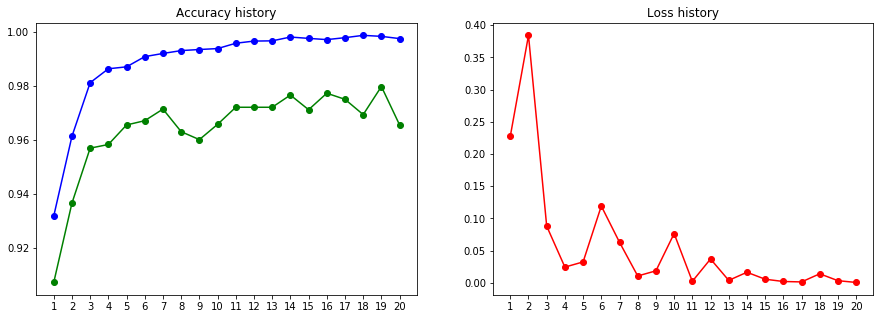

In [504]:
import matplotlib.pyplot as plt

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    best_accuracy = 0
    epoches = []
    history_train = []
    history_valid = []
    history_loss = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_rate: 0.6 }) # dropout rate set here
        
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        loss = get_loss(X_train, y_train)

        print("EPOCH {} ...".format(i+1))

        if False: # Print accuracy or not
            print("Train Accuracy = {:.3f}".format(train_accuracy) )        
            print("Validation Accuracy = {:.3f}".format(validation_accuracy) )        
            #test_accuracy = evaluate(X_test, y_test)
            #print("Test Accuracy = {:.3f}".format( test_accuracy ))
            print("loss = {:.3f}".format(loss))        
            print()
        
        # for graphing
        epoches.append(i+1)
        history_train.append(train_accuracy)
        history_valid.append(validation_accuracy)
        history_loss.append(loss)
        
        # keep best accuracy model we ever met
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            saver.save(sess, './lenet')
        
    print("Best Validation Accuracy = {:.3f}".format(best_accuracy))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5) )
    ax1.plot(epoches,history_train,'bo-',label="train")
    ax1.plot(epoches,history_valid,'go-',label="valid")
    ax1.set_xticks(epoches)
    ax1.set_xticklabels(epoches)
    ax1.set_title('Accuracy history')
    
    ax2.plot(epoches,history_loss,'ro-',label="loss")
    ax2.set_xticks(epoches)
    ax2.set_xticklabels(epoches)
    ax2.set_title('Loss history')
    
    plt.show()


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

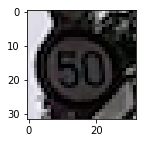

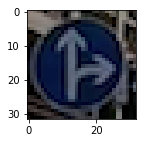

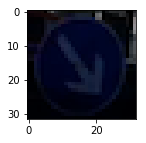

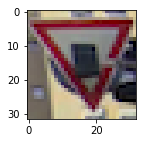

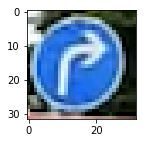

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import os

def list_images():
    filelist = os.listdir("images/")
    result = []
    for file in filelist:
        name,ext = os.path.splitext(file)
        if ext not in ['.png','.jpg']:
            continue
        filename = 'images/%s' % file
        result.append(filename)
    return result

filelist = os.listdir("images/")
for filename in list_images():
    img_orig = mpimg.imread(filename,0)
    visual(img_orig)

### Predict the Sign Type for Each Image

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


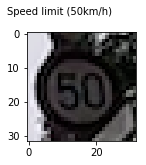

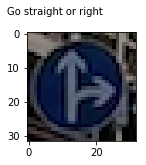

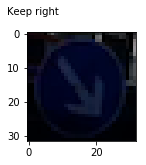

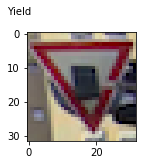

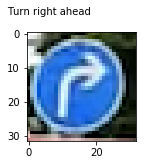

In [512]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import os
import re

total = 0
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for filename in list_images():
        # extract label from filename. ex: label is 5 when filename is 1[5].png 
        label = int(re.search("\[(\d+)]",filename).group(1))
        img_orig = mpimg.imread(filename,0)
        img = preprocess_img(img_orig)
        img = img.astype('float32')
        img = img.reshape(1,32,32,1)
        y=sess.run(tf.argmax(logits, 1), feed_dict={x: img})
        if(y[0] == label):
            correct+=1
        total+=1
        visual_with_label(img_orig,y[0])

### Analyze Performance

In [513]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("Accuracy for given images: %.3f%%" % ((correct/total)*100) )

Accuracy for given images: 100.000%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


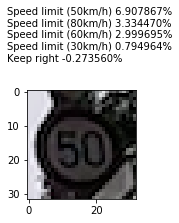

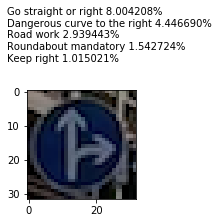

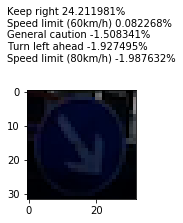

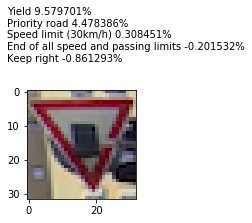

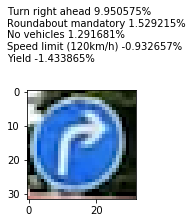

In [514]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for filename in list_images():
        img_orig = mpimg.imread(filename,0)
        img = preprocess_img(img_orig)
        img = img.astype('float32')
        img = img.reshape(1,32,32,1)
        y=sess.run(tf.nn.top_k(logits, 5), feed_dict={x: img})
        visual_with_top_k(img_orig,y)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


In [515]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


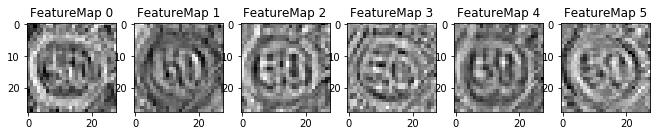

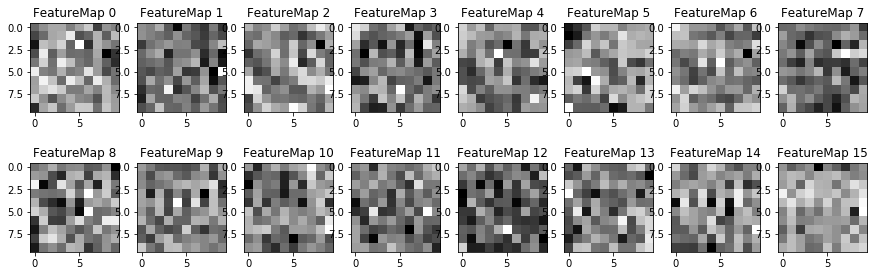

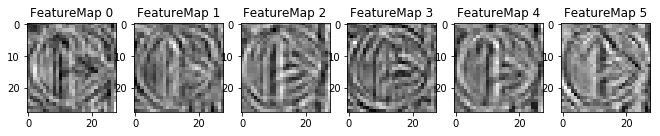

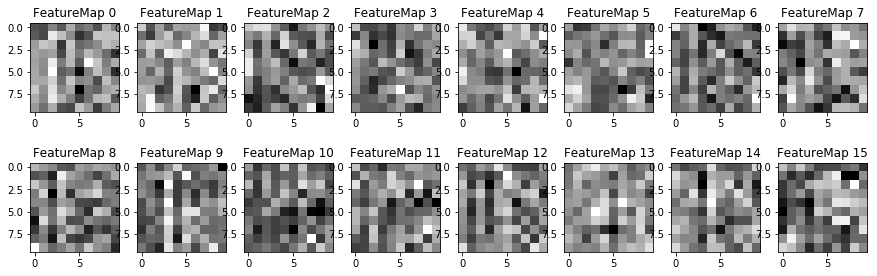

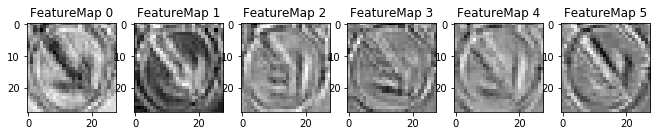

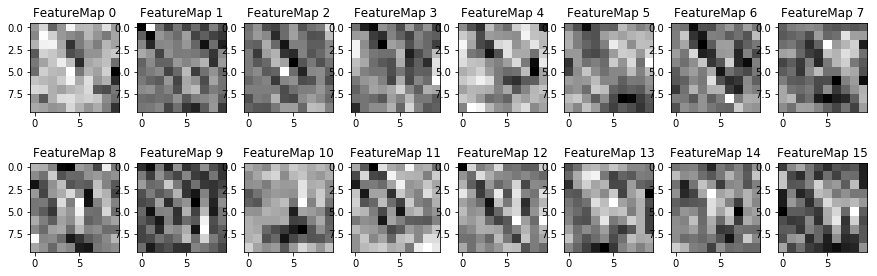

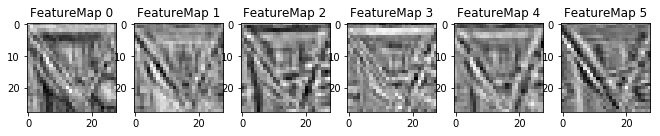

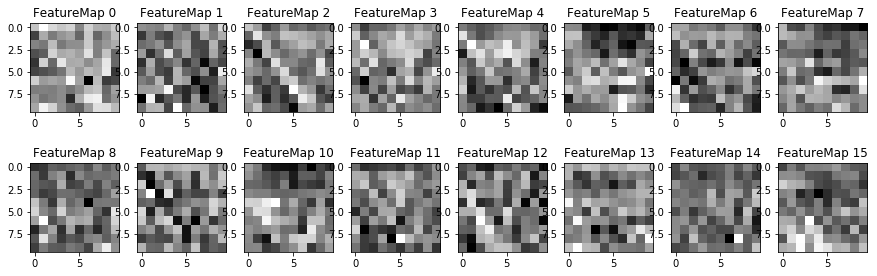

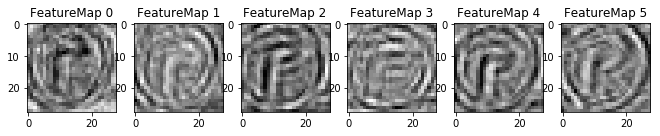

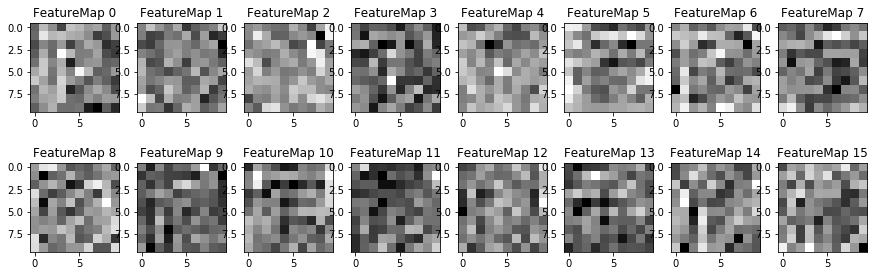

In [516]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    plt_count = 0
    for filename in list_images():
        img_orig = mpimg.imread(filename,0)
        img = preprocess_img(img_orig)
        img = img.astype('float32')
        img = img.reshape(1,32,32,1)
        plt_count+=1
        outputFeatureMap(img,out_conv1, plt_num=plt_count)
        plt_count+=1
        outputFeatureMap(img,out_conv2, plt_num=plt_count)